#Overview:

In this project I will analyze the Israel 2021 Knesset election along with the israeli socio-economic ranking data set which ranks each city as an integer in the range of 1 to 10. Most of the preliminary analysis will be with PCA.
In part 2, after Principal component analysis, I will use my tensorflow skills to create a classification model which will try to predict the ranking of the city based on the number of votes each main party got.



## Part 1:
## Does your socio-economic background determine your politics?

This is an analysis of the fourth election that took place in a two years span in israel. In march 23rd 2021 the israeli legislative leections took place in order to elect the 120 memebers of the 24th Israeli parliament called the knesset. 
For More information about the [2021 Israeli legislative election](https://en.wikipedia.org/wiki/2021_Israeli_legislative_election)

In this notebook, I will mainly use Principal Component Analysis to investigate the relationship between cities, ballots and "economic level of cities". By projecting each data point onto only the first few principal components to obain lower-dimensional data while preserving as much of the data's variation as possible.

I want to mostly focus on the big parties who passed the minimum threshold.
The parties are:
Likud, Yesh Atid, Shas , Blue and White, Yamina , Labor , UTJ , Yisrael Beiteinu, Religious Zionist, Joint List , New Hope, Meretz, Ra'am.
Since the dataset is in hebrew, I will change the column name of each party to be its English Equivalent so its easier to understand.

Libraries:

In [1]:
import numpy as np  
import pandas as pd  
from matplotlib import pyplot as plt
import random
import statsmodels.api as sm
import io
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from google.colab import files
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Data Sets include:
* Voting Per City
* Voting Per Ballot
* Socio Economic Ranking by the government.

More about the data can be read: [Here](https://votes24.bechirot.gov.il/) and [Here](https://www.cbs.gov.il/EN/pages/default.aspx)


parties_dict will help with translating the biggest parties into english.

In [2]:
top_parties=['Likud','Yesh Atid',"Shas",'Blue & White',"Yamina","Labor","UTJ","Israel Beiteinu","Religious Zionist","Joint List","New Hope","Meretz"
,"Ra'am"]

In [3]:
parties_dict={'מחל':"Likud","פה":"Yesh Atid","שס":"Shas",'כן':"Blue & White","ב":"Yamina","אמת":"Labor","ג":"UTJ",
              "ל":"Israel Beiteinu","ט":"Religious Zionist","ודעם":"Joint List","ת":"New Hope","מרצ":"Meretz","עם":"Ra'am"}

Uploading the datasets:

In [4]:
per_city=files.upload()
per_city=pd.read_csv('percity.csv',  encoding = 'iso-8859-8', index_col='שם ישוב')
per_city=per_city.rename(columns=parties_dict)
per_city.head(10)

Saving percity.csv to percity.csv


,סמל ועדה,סמל ישוב,בזב,מצביעים,פסולים,כשרים,Labor,Yamina,UTJ,Joint List,ז,זץ,Religious Zionist,י,יז,ינ,יף,יק,יר,כ,כך,Blue & White,Israel Beiteinu,Likud,Meretz,נ,ני,נר,Ra'am,Yesh Atid,ףז,צי,צכ,צף,ץ,ק,קי,קך,קץ,ר,רנ,רף,רק,Shas,New Hope,Unnamed: 46
שם ישוב,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
אבירים,6,1220,221,151,1,150,47,0,0,3,0,0,2,0,3,0,0,0,0,0,0,16,2,5,31,0,0,0,0,27,0,0,0,0,0,0,0,0,0,5,0,0,0,1,8,NaN
אדירים,5,113,234,180,0,180,1,7,4,0,0,0,9,0,1,0,0,0,0,0,0,3,0,84,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,61,6,NaN
אושה,8,278,382,276,0,276,72,7,0,3,0,0,0,0,2,0,0,1,0,0,0,37,8,24,20,0,0,0,0,86,0,0,0,0,0,0,0,0,0,1,0,0,0,0,15,NaN
אחווה,17,1157,183,145,0,145,14,4,0,0,0,0,4,0,0,0,0,0,0,0,0,36,3,27,10,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,NaN
איבים,17,338,138,40,0,40,0,4,0,0,0,1,10,0,0,0,0,0,0,0,0,5,0,17,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,NaN
אלעריאן,9,1316,130,84,0,84,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
אלומות,4,330,316,205,0,205,45,12,1,0,0,0,2,0,2,0,0,0,0,0,0,26,3,24,31,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9,NaN
אלוני יצחק,9,868,125,23,0,23,5,1,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0,1,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,NaN
אליעד,4,4002,311,222,3,219,46,21,0,0,0,0,8,0,1,0,0,0,0,0,0,27,12,18,11,0,0,0,0,54,1,0,0,0,0,0,0,0,0,3,0,0,0,0,17,NaN


In [5]:
per_ballot=files.upload()
per_ballot=pd.read_csv('perballot.csv',  encoding = 'iso-8859-8', index_col='שם ישוב')
per_ballot=per_ballot.rename(columns=parties_dict)
per_ballot.head(10)

Saving perballot.csv to perballot.csv


,סמל ועדה,ברזל,סמל ישוב,קלפי,ריכוז,שופט,בזב,מצביעים,פסולים,כשרים,Labor,Yamina,UTJ,Joint List,ז,זץ,Religious Zionist,י,יז,ינ,יף,יק,יר,כ,כך,Blue & White,Israel Beiteinu,Likud,Meretz,נ,ני,נר,Ra'am,Yesh Atid,ףז,צי,צכ,צף,ץ,ק,קי,קך,קץ,ר,רנ,רף,רק,Shas,New Hope,Unnamed: 50
שם ישוב,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
אבירים,6,3238,1220,1.0,1,0,221,151,1,150,47,0,0,3,0,0,2,0,3,0,0,0,0,0,0,16,2,5,31,0,0,0,0,27,0,0,0,0,0,0,0,0,0,5,0,0,0,1,8,NaN
אדירים,5,1788,113,1.0,1,0,234,180,0,180,1,7,4,0,0,0,9,0,1,0,0,0,0,0,0,3,0,84,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,61,6,NaN
אושה,8,4113,278,1.0,1,0,382,276,0,276,72,7,0,3,0,0,0,0,2,0,0,1,0,0,0,37,8,24,20,0,0,0,0,86,0,0,0,0,0,0,0,0,0,1,0,0,0,0,15,NaN
אחווה,17,10449,1157,1.0,1,0,183,145,0,145,14,4,0,0,0,0,4,0,0,0,0,0,0,0,0,36,3,27,10,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,NaN
איבים,17,10450,338,1.0,1,0,138,40,0,40,0,4,0,0,0,1,10,0,0,0,0,0,0,0,0,5,0,17,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,NaN
אלעריאן,9,4332,1316,1.0,3,0,130,84,0,84,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
אלומות,4,1553,330,1.0,1,0,316,205,0,205,45,12,1,0,0,0,2,0,2,0,0,0,0,0,0,26,3,24,31,0,0,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9,NaN
אלוני יצחק,9,4798,868,1.0,2,0,125,23,0,23,5,1,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0,1,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,NaN
אליעד,4,1613,4002,1.0,1,0,311,222,3,219,46,21,0,0,0,0,8,0,1,0,0,0,0,0,0,27,12,18,11,0,0,0,0,54,1,0,0,0,0,0,0,0,0,3,0,0,0,0,17,NaN


In [6]:
socio_economic=files.upload()
socio_economic= pd.read_excel('economicsheet.xlsx', index_col='name')
socio_economic.head(10)

Saving economicsheet.xlsx to economicsheet.xlsx


,set_code,population,index_value,eco_level
name,,,,
עוזייר,528,3047.0,-1.679,1
רומאנה,539,1129.0,-1.566,2
רומת הייב,997,1882.0,-1.237,2
חמאם,993,1410.0,-0.738,3
תרבין א-צאנע (יישוב),1346,437.0,-3.103,1
מולדה,1360,295.0,-2.856,1
אום בטין,1358,3080.0,-2.508,1
אל סייד,1359,3384.0,-2.288,1
מכחול,1343,395.0,-2.205,1


# PCA on "per ballot" data set

## PCA as is:

What I wanna do now is to perfom pca on per ballot data. Let's see how the parties cluster together.


Keeping just the parties, dropping all irrelevant columns.

In [7]:
per_ballot_data=per_ballot.copy(deep=True)
per_ballot_data=per_ballot_data.drop(['סמל ועדה', 'ברזל','סמל ישוב','קלפי','ריכוז','שופט','בזב','מצביעים','פסולים','כשרים','Unnamed: 50'], axis=1)

In [8]:
per_ballot_data.shape

(12926, 39)

so we have 39 parties and 12926 ballots.
Let's apply the PCA algorithms to our data:



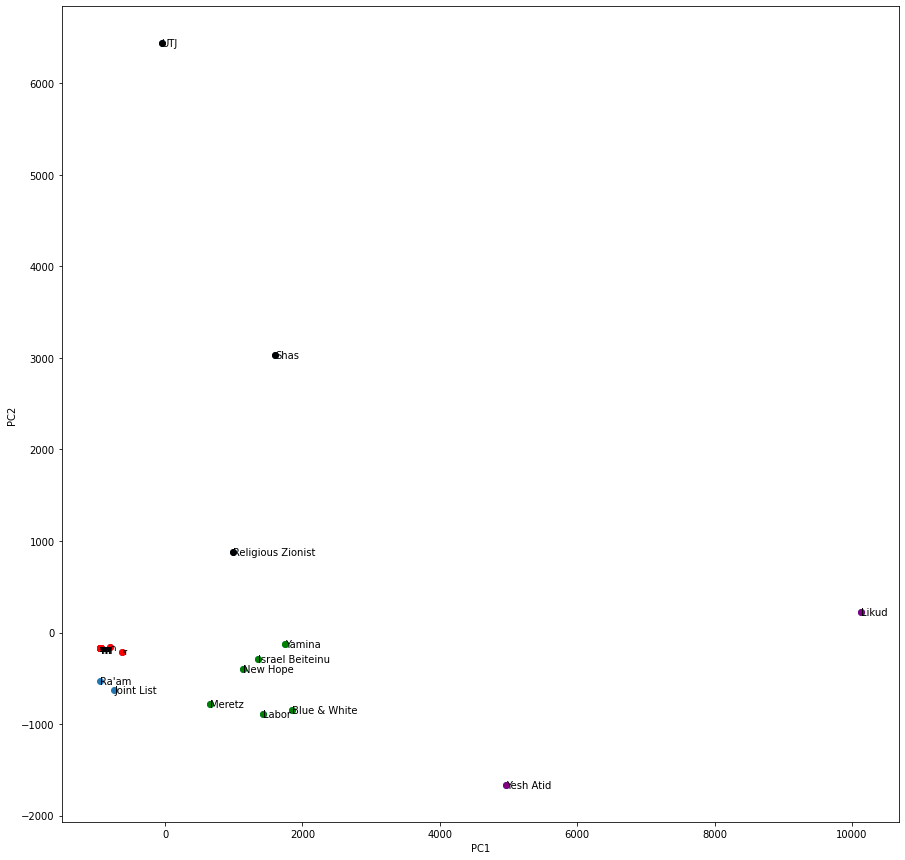

In [9]:
pca=PCA(n_components=2)
per_ballot_data_pca=pca.fit_transform(per_ballot_data.T)

per_ballot_data_pca=pd.DataFrame(per_ballot_data_pca)
namebank=per_ballot_data.columns
namebank=list(namebank)
x = per_ballot_data_pca.iloc[:,0]
y = per_ballot_data_pca.iloc[:,1]
plt.figure(figsize=(15,15))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(x,y)
for i in range(len(x)):
  plt.text(x.iloc[i],y.iloc[i],namebank[i],verticalalignment='center')
  if (x.iloc[i]<-1 and 0>y.iloc[i]>-250):
    plt.scatter(x[i],y[i],c="r")
  elif (0<x.iloc[i]<3000 and -1000<y.iloc[i]<-1):
    plt.scatter(x[i],y[i],c='g')
  elif (y.iloc[i]>500):
    plt.scatter(x[i],y[i],c='black')
  elif (x.iloc[i]>4000):
    plt.scatter(x[i],y[i],c='purple')


* First of all, We can see that all the smaller parties in 
<font color='red'>red</font>, which did not pass the minimum threshold are really close together. 
* We can see that the bigger parties are spread out.
* We can see that 6 out of the 8 coalition parties are also clustered very closely in <font color='green'>green</font>

* Religious-Jewish Parties are all in <font color='black'>black</font> at the upper part of the Graph.

* The two leading parties in <font color='purple'>purple</font> Likud and Yesh Atid are both on the right side of the graph, it can be argued that they are pretty much alone.
* The two Arab parties in blue: Ra'am and Joint List also create their own little cluster.

I think that that coolest finding from this non-normalized PCA is that despite their differences (right wing-left-wing religious/ secular etc.) 75% of the coalition parties clustered together even before coalition was formed. 

## PCA Normalized:


I would like to use the same data set but this time I would like to normalize each vector to be length 1 first and then performing the PCA transformation.

Text(0, 0.5, 'PC 2')

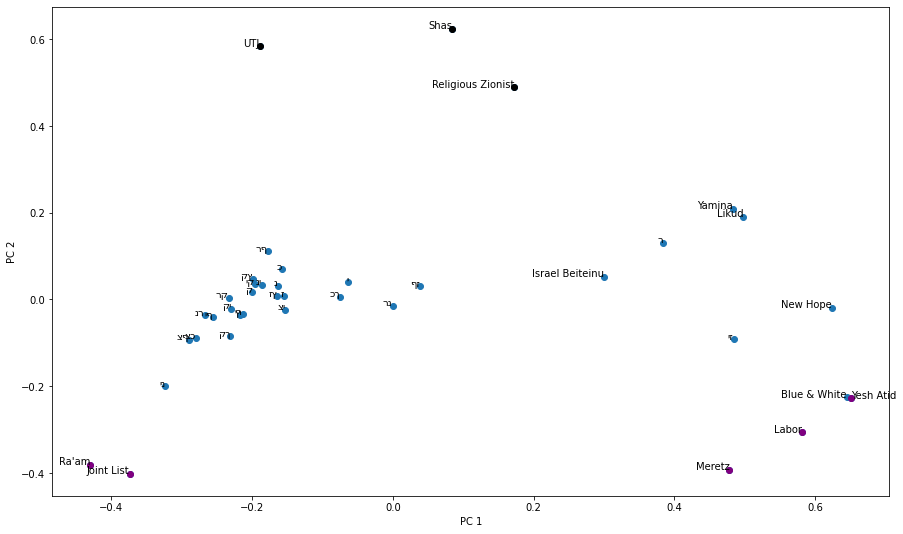

In [10]:
df2=per_ballot_data.copy(deep=True)
df2_bet = (df2.T).div(((df2.T.pow(2).sum(axis=1)).pow(0.5)), axis=0)
df2_bet = df2_bet.fillna(0)
pca_bet = PCA(n_components=2)
pca_bet_vals = pca_bet.fit_transform(df2_bet)
pca_bet_x_vals = pca_bet_vals[:,0]
pca_bet_y_vals = pca_bet_vals[:,1]
fig, ax = plt.subplots(figsize=(15,9))
ax.scatter(pca_bet_x_vals, pca_bet_y_vals)
for i, name in enumerate([x[::] for x in df2_bet.index]):
  if (name=="Yesh Atid"):
    ax.annotate(name, (pca_bet_x_vals[i], pca_bet_y_vals[i]),ha='left')
  else:
    ax.annotate(name, (pca_bet_x_vals[i], pca_bet_y_vals[i]),ha='right')
  if (pca_bet_y_vals[i]< -0.226):
    ax.scatter(pca_bet_x_vals[i],pca_bet_y_vals[i],c='purple')
  elif (pca_bet_y_vals[i]>0.4):
    ax.scatter(pca_bet_x_vals[i],pca_bet_y_vals[i],c='black')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

**Colors Legend**
* Jewish-religious partys in Black (all have "religious conservatism" in their ideology section on wikipedia)
* <font color='purple'>Two-state solutions parties in purple</font>
 (according to the wikipedia articles of each party, under their "ideology" section)

Since this time I scaled the vectors to be of length one, We can see that each party got its own place on the graph- relative to the other parties.
For this reason we can see that the smaller parties kind of cluster together and the bigger parties are more "spread out".



It is pretty safe to assume that the y axis could stand for the amount of "Jewish Religiosity of the party".

We can see that greater Y values are correlated with more Jewish Religious parties such as UTJ, Shas and Religious Zionist. 
On the other hand, Negative Y values parties such as Meretz, Labor Ra'am and Joint List are either islamic or secular. I.E less (ultra) orthodox jewish. 
According to wikipedia, these four parties have "Two-state solution" In their Ideology section.


Note that the parties are arranged a bit differently. For Example, We can see that Blue & White and Yesh Atid are really close to eachother, while on the non-normalized graph Yesh Atid was alone. We can also see that Yamina is very very close to the Likud party, and pretty far from the others. While in the non-normalized PCA graph Yamina was with the the parties which ended up being part of the coalition of 2021.

# PCA on "per city" data set

Let's look at the 13 biggest parties. Let's see what are the Socio-Economic levels of each party's voters.

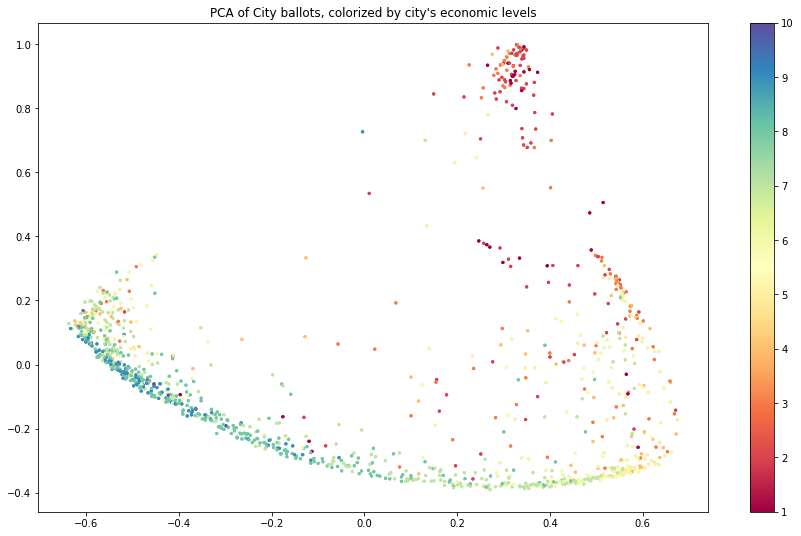

In [11]:
per_city_data=per_city.copy(deep=True)
per_city_data=per_city_data.drop(['סמל ועדה','בזב','מצביעים','פסולים','Unnamed: 46'], axis=1)
merged_per_city_data=per_city_data.join(socio_economic.set_index('set_code'),on="סמל ישוב")
pca_per_city = normalize(merged_per_city_data[top_parties].T,axis=0)
fig, ax = plt.subplots(figsize=(15,9))
ax.scatter(pca.fit_transform(pca_per_city.T) [:, 0],pca.fit_transform(pca_per_city.T) [:, 1], c = merged_per_city_data['eco_level'],s=5,cmap='Spectral')
ax.set_title("PCA of City ballots, colorized by city's economic levels")
plt.colorbar(ax.scatter(pca.fit_transform(pca_per_city.T) [:, 0],pca.fit_transform(pca_per_city.T) [:, 1], c = merged_per_city_data['eco_level'],s=5,cmap='Spectral'))

The Socio Economic level legend is on the Right. Lower numbers /  "redder" colors mean low socionomic levels and poverty. Higher numbers such as 8,9,10 "Bluer" colors means high socio economic levels and wealthiness.

We can infer from this plot that poorer cities tend to vote similarly, as can be observed from the red clusted at the upper half of the graph. Additionally, we can see that richer cities also tend to vote similarly.  as can be seen on the lower-left part of the graph. 

We have a good overall idea with this plot and the colors where the richer and poorer cities are located on the graph. We can use this map to see where most of the votes of each of the parties come from.
Let's calculate the support percentage each party gets per city ballot. With that we can see, for example if most of Yesh Atid's voters are poor/rich/middleclass.

To Calculate the support percentage each party gets in a specific city we can divide each row(city ballot) by the valid votes of that specific row (city-ballot)

Let's compare the above "map" with the party that got most votes overall, Likud.

Text(0.5, 1.0, "PCA of City ballots, colorized by city's voting percentage for the Likud")

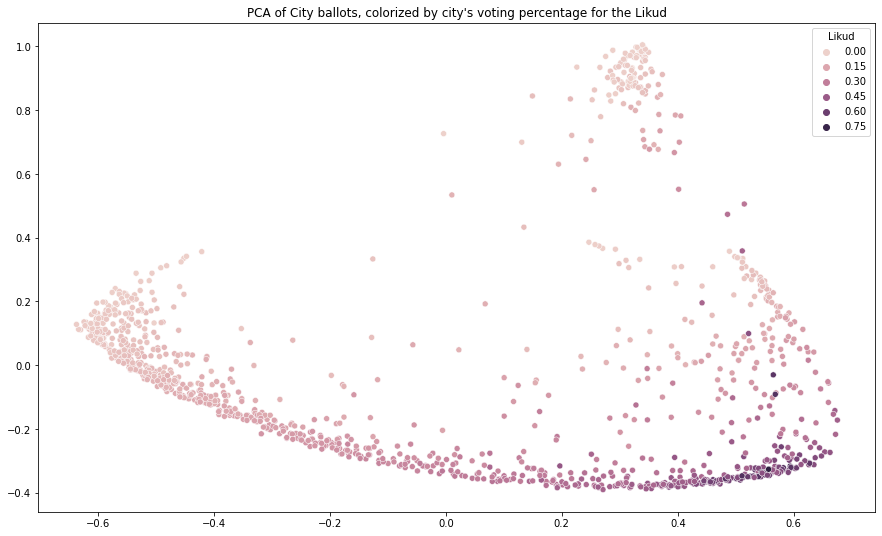

In [12]:
support_data=merged_per_city_data[top_parties].div(merged_per_city_data.כשרים, axis=0)
fig, ax = plt.subplots(figsize=(15,9))
sns.scatterplot(x=pca.fit_transform(pca_per_city.T) [:, 0], y=pca.fit_transform(pca_per_city.T) [:, 1], hue=support_data.columns[0], data=support_data)
plt.title("PCA of City ballots, colorized by city's voting percentage for the Likud")

By comparing this PCA graph with the one above, we can see that most of the Likud's electoral power comes from the socio economic background of around 5-7.
The likud barely gets any votes from the super rich or the super poor.

Let's plot the information for the rest of the top parties.

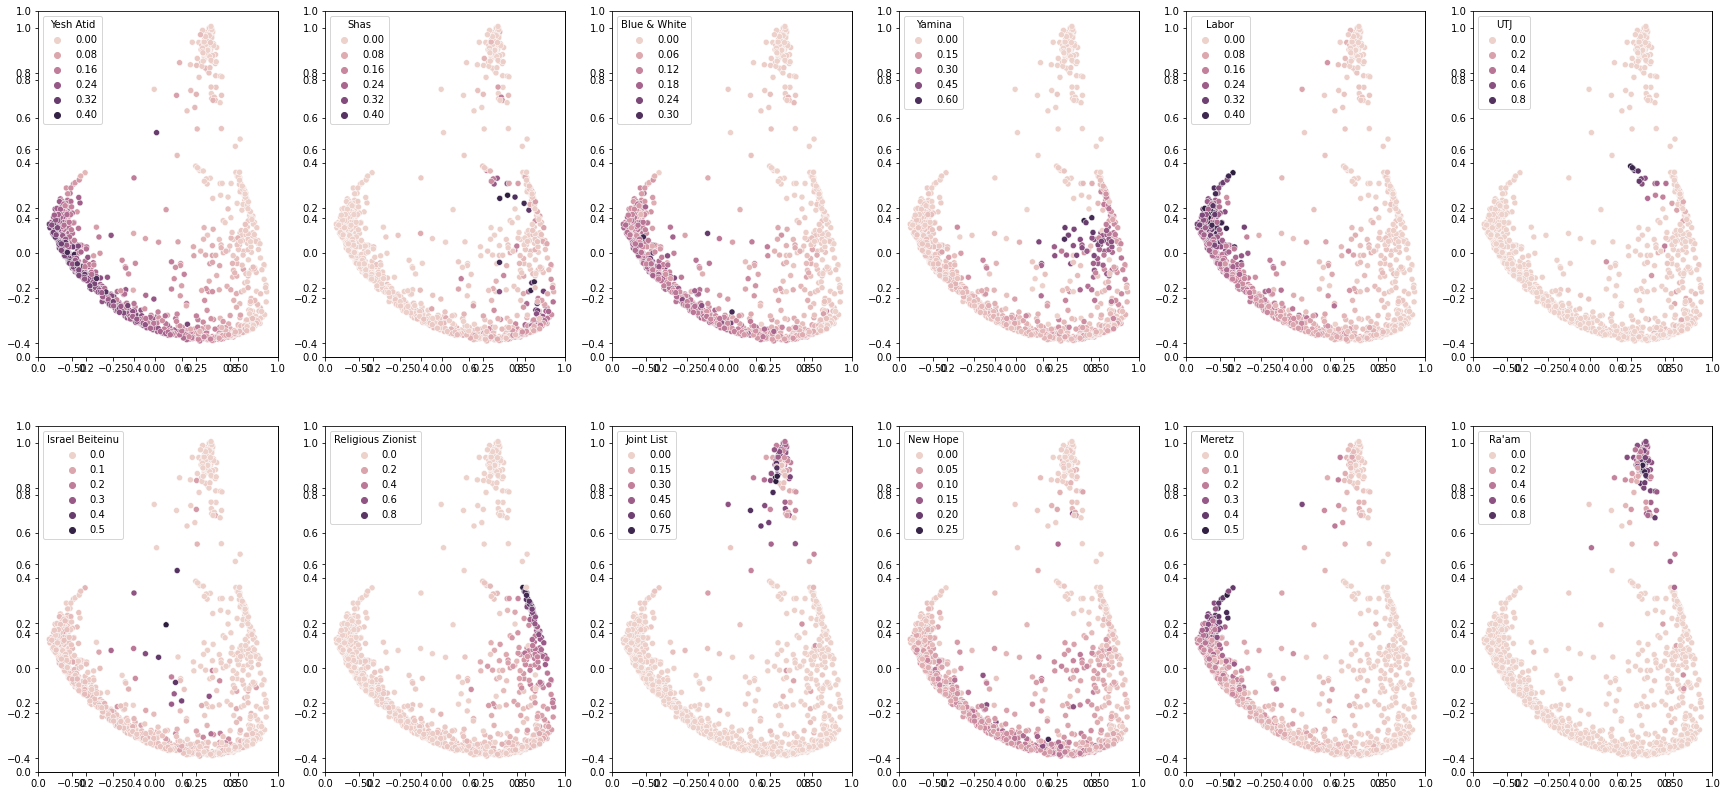

In [13]:
support_data.drop(labels='Likud',inplace=True,axis=1)
fig, ax = plt.subplots(2, 6, figsize=(30,14))
for i in range(len(support_data.columns)):
  fig.add_subplot(2,6,i+1)
  sns.scatterplot(x=pca.fit_transform(pca_per_city.T) [:, 0], y=pca.fit_transform(pca_per_city.T) [:, 1], hue=support_data.columns[i], data=support_data)


We can see, for example:
* That UTJ and Joint List have high support percentage in cities with lower socio economic ranking.
* Yesh Atid has high support in cities with higher socio-economic ranking
*Labor and Meretz seem to have a similar mix of high and middle socio-economic ranked citied.

## Part 2:
### Deep Learning: Predicting The Socio-Economic Ranking of a City Based on the number of votes each of the 13 main party got.

Here I will try to create a MLP algorithm to predict each of the city's socio-economic ranking based on the votes each main party got. (out of the 13 main ones) 


I'm specifically focusing on Keras/TensorFlow because I want to get better with those libraries. I know there are probably better ways to go about this problem.


### Some Preprocessing of the data set:
let's use the merged_per_city_data from before, which has the merged cities votes and the socio economic level.

In [14]:
merged_per_city_data

,סמל ישוב,כשרים,Labor,Yamina,UTJ,Joint List,ז,זץ,Religious Zionist,י,יז,ינ,יף,יק,יר,כ,כך,Blue & White,Israel Beiteinu,Likud,Meretz,נ,ני,נר,Ra'am,Yesh Atid,ףז,צי,צכ,צף,ץ,ק,קי,קך,קץ,ר,רנ,רף,רק,Shas,New Hope,population,index_value,eco_level
שם ישוב,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
אבירים,1220,150,47,0,0,3,0,0,2,0,3,0,0,0,0,0,0,16,2,5,31,0,0,0,0,27,0,0,0,0,0,0,0,0,0,5,0,0,0,1,8,194.0,0.734,7.0
אדירים,113,180,1,7,4,0,0,0,9,0,1,0,0,0,0,0,0,3,0,84,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,61,6,267.0,0.011,5.0
אושה,278,276,72,7,0,3,0,0,0,0,2,0,0,1,0,0,0,37,8,24,20,0,0,0,0,86,0,0,0,0,0,0,0,0,0,1,0,0,0,0,15,462.0,0.873,7.0
אחווה,1157,145,14,4,0,0,0,0,4,0,0,0,0,0,0,0,0,36,3,27,10,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,159.0,1.085,8.0
איבים,338,40,0,4,0,0,0,1,10,0,0,0,0,0,0,0,0,5,0,17,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,277.0,-2.401,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
קורנית,1179,491,89,18,0,1,0,0,3,0,1,0,0,0,0,0,0,73,10,32,98,0,0,0,0,150,0,0,0,0,0,0,0,0,0,1,0,0,0,0,15,868.0,1.906,9.0
שורשים,1235,290,60,19,0,3,0,1,1,0,1,0,0,0,0,0,0,38,7,32,21,0,0,0,0,81,0,0,0,0,0,0,0,0,0,1,0,0,0,0,25,476.0,1.530,8.0
שכניה,1160,445,101,17,0,3,0,0,4,0,4,0,0,0,0,0,0,61,12,14,68,0,0,0,0,121,0,0,0,0,0,0,0,0,0,3,0,0,0,1,36,740.0,1.635,9.0


In [15]:
## y vals= economic level.
### Let's define the ratio each party in a city gets by the votes the party got in a specific city, divided by the total valid votes in that said city.
merged_per_city_data.dropna(inplace=True)
Y=merged_per_city_data['eco_level']
ratio_data=merged_per_city_data[top_parties].div(merged_per_city_data.כשרים, axis=0)
#ratio_data=tf.convert_to_tensor(ratio_data)
## Putting categories to be in a range that tensorflow will accept. 
## We can always add one to the output to get the "real label" back.
Y_minusone=Y-1
ratio_data

,Likud,Yesh Atid,Shas,Blue & White,Yamina,Labor,UTJ,Israel Beiteinu,Religious Zionist,Joint List,New Hope,Meretz,Ra'am
שם ישוב,,,,,,,,,,,,,
אבירים,0.033333,0.180000,0.006667,0.106667,0.000000,0.313333,0.000000,0.013333,0.013333,0.020000,0.053333,0.206667,0.0
אדירים,0.466667,0.011111,0.338889,0.016667,0.038889,0.005556,0.022222,0.000000,0.050000,0.000000,0.033333,0.000000,0.0
אושה,0.086957,0.311594,0.000000,0.134058,0.025362,0.260870,0.000000,0.028986,0.000000,0.010870,0.054348,0.072464,0.0
אחווה,0.186207,0.255172,0.013793,0.248276,0.027586,0.096552,0.000000,0.020690,0.027586,0.000000,0.055172,0.068966,0.0
איבים,0.425000,0.000000,0.025000,0.125000,0.100000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
נווה זיו,0.294258,0.191388,0.031100,0.100478,0.100478,0.064593,0.000000,0.038278,0.045455,0.002392,0.069378,0.043062,0.0
קורנית,0.065173,0.305499,0.000000,0.148676,0.036660,0.181263,0.000000,0.020367,0.006110,0.002037,0.030550,0.199593,0.0
שורשים,0.110345,0.279310,0.000000,0.131034,0.065517,0.206897,0.000000,0.024138,0.003448,0.010345,0.086207,0.072414,0.0


Lucky for us, we get values between 0 and 1. Which is great for our deep learning algorithm. Note the shape, 1171 cities and 13 parties. Exactly what we wanted. Let's move on to create our train/test split.

In [16]:
Y_minusone.max(),Y_minusone.min()

(9.0, 0.0)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(ratio_data,
                                                    Y_minusone,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    )
# converting to tensor object for the Neural Network.
X_train=tf.convert_to_tensor(X_train)
X_test=tf.convert_to_tensor(X_test)
y_train=tf.convert_to_tensor(y_train)
y_test=tf.convert_to_tensor(y_test)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

(TensorShape([936, 13]),
 TensorShape([235, 13]),
 TensorShape([936]),
 TensorShape([235]))

In [18]:
## input shape
X_train[0].shape

TensorShape([13])

### Creating our Model:

Let's create a multilayer perceptron model. Let's start with a simple model and work on it.

Let's define a function that will automatically build & compile the neural network so we don't have to rewrite it every time.


In [19]:
def Build_A_Model(model_layers=1,units_per_layer=10,activation_in_layer="relu",final_activation="softmax",optimiser="SGD"):
  ### Building the model...
  model=tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=[13]))
  for layers in range(model_layers):
    model.add(tf.keras.layers.Dense(units=units_per_layer,activation=activation_in_layer))
  model.add(tf.keras.layers.Dense(10,activation=final_activation))

#### tf.keras.losses.CategoricalCrossentropy() <---- EXPECT THE LABELS TO BE IN ONE-HOT REPRESENTATION
#### tf.keras.losses.SparseCategoricalCrossentropy() <--- expect the labels to be "as is"


  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=optimiser,
                metrics=["accuracy"]
                )
  return model

Let's use 2 layers,5 units per layer. We HAVE to have the output activation(final_activation) as softmax. keep the optimiser to be SGD and keep the activation layer in the inner layers to be relu. Additionally, let's use 5 epochs. Finally, let's use the test data as validation while fitting just for the sake of it.

In [20]:
model_1=Build_A_Model(model_layers=2,units_per_layer=5,)
# Let's fit the model and keep the history
tf.random.set_seed(42)
history_model_1=model_1.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test))

Epoch 1/10
30/30 [==============================] - 1s 8ms/step - loss: 2.2984 - accuracy: 0.1282 - val_loss: 2.2861 - val_accuracy: 0.1489
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 2.2824 - accuracy: 0.2297 - val_loss: 2.2714 - val_accuracy: 0.2213
Epoch 3/10
30/30 [==============================] - 0s 2ms/step - loss: 2.2677 - accuracy: 0.2286 - val_loss: 2.2578 - val_accuracy: 0.2170
Epoch 4/10
30/30 [==============================] - 0s 2ms/step - loss: 2.2541 - accuracy: 0.2286 - val_loss: 2.2450 - val_accuracy: 0.2170
Epoch 5/10
30/30 [==============================] - 0s 2ms/step - loss: 2.2414 - accuracy: 0.2265 - val_loss: 2.2330 - val_accuracy: 0.2170
Epoch 6/10
30/30 [==============================] - 0s 2ms/step - loss: 2.2297 - accuracy: 0.2265 - val_loss: 2.2217 - val_accuracy: 0.2170
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 2.2186 - accuracy: 0.2276 - val_loss: 2.2113 - val_accuracy: 0.2170
Epoch 8/10
30/30 [==

Our base model is pretty bad, and after a lot of experimentation the layer called Exponential Linear Unit (SELU) seems to be the most promising.
After A lot of experimentation, I noticed that its super hard to even reach the 40% accuracy mark. So What I'm gonna do is try to use the Keras Tuner. 
* Sadly, I can't use the above function for the Keras_tuner so I will have to recreate another function.



downloading the Keras-tuner.


In [21]:
pip install -q -U keras-tuner

     |████████████████████████████████| 97 kB 6.0 MB/s 


In [22]:
import keras_tuner as kt
from tensorflow import keras

Before Declaring our tuner, we have to create the appropriate model building function.


In [23]:
def Build_Model(hp):
  model=tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=[13]))
  for layers in range(hp.Int("Num_layers",min_value=10,max_value=120,step=5)):
    model.add(tf.keras.layers.Dense(units=hp.Int('units_'+str(layers),
                                                 min_value=32,
                                                 max_value=512,
                                                 step=32),
                                    activation='selu'))
  model.add(tf.keras.layers.Dense(10,activation='softmax'))
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate',[1e-2,1e-3,1e-4])
                    
                ),
                metrics=["accuracy"]
                )
  return model

In [24]:
tuner = kt.RandomSearch(
    Build_Model,
    objective='val_accuracy',
    max_trials=1,
    executions_per_trial=1,
    seed=42,
    directory='project',
    project_name='testing stuff'
)

tuner.search(X_train,y_train,epochs=10,validation_data=(X_test,y_test))
best_model=tuner.get_best_models()[0]

Trial 1 Complete [00h 00m 14s]
val_accuracy: 0.4297872483730316

Best val_accuracy So Far: 0.4297872483730316
Total elapsed time: 00h 00m 14s
INFO:tensorflow:Oracle triggered exit


In [25]:
tf.random.set_seed(42)
best_model_history=best_model.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),epochs=10,)

Epoch 1/10
30/30 [==============================] - 4s 36ms/step - loss: 1.5352 - accuracy: 0.4049 - val_loss: 1.5142 - val_accuracy: 0.4085
Epoch 2/10
30/30 [==============================] - 0s 15ms/step - loss: 1.5205 - accuracy: 0.4092 - val_loss: 1.5434 - val_accuracy: 0.4255
Epoch 3/10
30/30 [==============================] - 1s 17ms/step - loss: 1.5056 - accuracy: 0.4380 - val_loss: 1.6327 - val_accuracy: 0.3872
Epoch 4/10
30/30 [==============================] - 0s 17ms/step - loss: 1.5024 - accuracy: 0.4167 - val_loss: 1.5435 - val_accuracy: 0.4000
Epoch 5/10
30/30 [==============================] - 0s 15ms/step - loss: 1.4722 - accuracy: 0.4220 - val_loss: 1.5686 - val_accuracy: 0.3574
Epoch 6/10
30/30 [==============================] - 1s 18ms/step - loss: 1.4787 - accuracy: 0.4359 - val_loss: 1.4480 - val_accuracy: 0.4511
Epoch 7/10
30/30 [==============================] - 1s 17ms/step - loss: 1.4439 - accuracy: 0.4509 - val_loss: 1.4715 - val_accuracy: 0.4468
Epoch 8/10
30

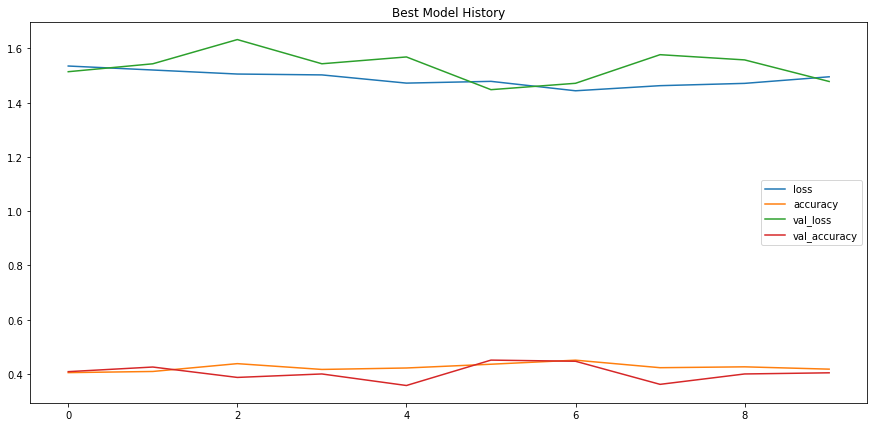

In [26]:
pd.DataFrame(best_model_history.history).plot(title="Best Model History",figsize=(15,7))

After exhausting everything I could which included:

* Building many different models by hand
* Using the keras_tuner

The best validation accuracy I could get is pretty bad. I think this is because the data set is very small. More data is needed to feed the Neural Network. In my opinion this is a success story because I've now learned that We need a lot of data to train a good neural network model. This is a great way to showcase where and when Neural Networks are actually not that good.


I think I would need more data to actually train the model effectively and reach higher accuracy. As we far as I know, deep learning models require a lot of data.
All in all, even though I did not get good accuracies, I learned how to do basic classification using TensorFlow. I also learned how to user the Keras Tuner which I am sure will come in handy in the future.



I am keeping this part 2, which is a "failure" because this code, in my opinion, is important.